In [1]:
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chisquare, expon, lognorm, norm, poisson, zipf, ks_2samp
import re
from collections import Counter, OrderedDict
import mmh3

warnings.filterwarnings('ignore')


In [2]:
def chisquare_test(sample, power=1.16, beta=3):
    unique, counts = np.unique(sample, return_counts=True)
    counts[::-1].sort()

    frequencies = np.array([1.0 / np.power(i + beta, power) for i in range(1, len(counts) + 1)])
    zipf_counts = np.ceil(len(sample) * frequencies / frequencies.sum())

    return chisquare(counts, zipf_counts)[1]

def ks2_test(sample, power=1.16, beta=3):
    unique, counts = np.unique(np.ceil(sample).astype(int), return_counts=True)
    counts[::-1].sort()

    frequencies = np.array([1.0 / np.power(i + beta, power) for i in range(1, len(counts) + 1)])
    zipf_counts = np.ceil(len(sample) * frequencies / frequencies.sum()).astype(int)

    zipf_sample = []
    for i in range(len(counts)):
        zipf_sample.extend([i + 1 for j in range(zipf_counts[i])])

    return ks_2samp(sample, zipf_sample)[1]

tests = {'chi': chisquare_test}
#'ks2': ks2_test}


In [3]:
def add_noise(sample, level, distrib, args):
    rand_values = np.random.rand(len(sample))
    for i in range(len(sample)):
        if rand_values[i] < level:
            sample[i] = distrib.rvs(*args)


In [4]:
file = open('war_and_peace.txt', 'r')
text = file.read().lower()
words = re.sub('\W', ' ', text).split()[:500000]


In [5]:
def get_sample(words):
    word_counts = Counter(words)
    sorted_word_counts = sorted(word_counts.items(), key=lambda kv: -kv[1])
    sorted_word_counts = dict([(sorted_word_counts[i][0], i + 1) for i in range(len(sorted_word_counts))])
    return np.array([sorted_word_counts[word] for word in words])


In [6]:
def coordinate_descent(f, parameters):
    params = parameters.copy()
    step = 0.01

    p = True
    while (p):
        p = False
        for i in range(len(params)):
            while (True):
                back_params = params.copy()
                back_params[i] -= step

                forward_params = params.copy()
                forward_params[i] += step

                next_step = np.argmin(np.array([f(back_params), f(params), f(forward_params)]))

                if next_step == 0:
                    params[i] = back_params[i]
                    p = True
                elif next_step == 2:
                    params[i] = forward_params[i]
                    p = True
                else:
                    break
    return params


In [7]:
def parameter_estimation(sample, params):
    unique, counts = np.unique(sample, return_counts=True)
    counts[::-1].sort()

    def f(params):
        power, beta = params
        frequencies = np.array([1.0 / np.power(i + beta, power) for i in range(1, len(counts) + 1)])
        zipf_counts = np.ceil(len(sample) * frequencies / frequencies.sum())
        # return sum(np.abs(counts-zipf_counts))
        return chisquare(counts, zipf_counts)[0]

    return coordinate_descent(f, params)


# Baseline

In [8]:
pvalues_n = defaultdict(list)
sample_sizes = [i * 10000 for i in range(1, 51)]

for n in sample_sizes:
    sample = get_sample(words[:n])
    for name in tests:
        pvalues_n[name].append(tests[name](sample))


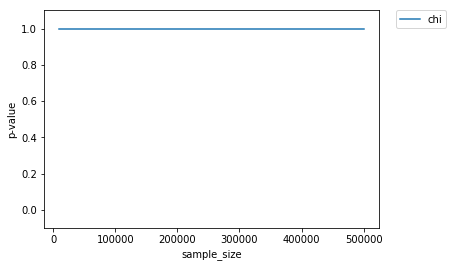

In [9]:
plt.ylim(-0.1, 1.1)
for name in tests:
    plt.plot(sample_sizes, pvalues_n[name], label=name)

plt.xlabel('sample_size')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [10]:
pvalues_l = defaultdict(list)
num_blocks = 50
num_noise_levels = 30

noise_levels = np.linspace(0, num_noise_levels / 100, num=num_noise_levels + 1)
for name in tests:
    pvalues_l[name] = np.zeros(len(noise_levels))
word_blocks = np.split(np.array(words), num_blocks)

for k in range(num_blocks):
    orig_sample = get_sample(word_blocks[k])
    for i in range(num_noise_levels):
        sample = orig_sample.copy()
        add_noise(sample, noise_levels[i], lognorm, [1])
        for name in tests:
            pvalues_l[name][i] += tests[name](sample)

for name in tests:
    pvalues_l[name] /= num_blocks


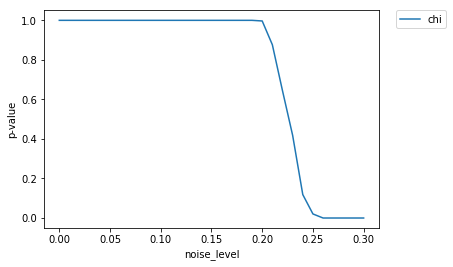

In [11]:
for name in tests:
    plt.plot(noise_levels, pvalues_l[name], label=name)
plt.xlabel('noise_level')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [12]:
# type I errors
def get_false_positive(test, words, N=100):
    false_positive = 0;
    word_blocks = np.split(np.array(words), N)
    for i in range(N):
        sample = get_sample(word_blocks[i])
        if test(sample) <= 0.05:
            false_positive += 1
    return false_positive / N

# type II errors
def get_false_negative(test, N=1000, sample_size=1000, distrib=lognorm, args=[10]):
    true_negative = 0;
    for i in range(N):
        sample = np.ceil(distrib.rvs(*args, size=sample_size))
        if test(sample) > 0.05:
            true_negative += 1
    return true_negative / N


In [13]:
print('false_positive')
for name in tests:
    print(name, get_false_positive(tests[name], words))


false_positive
chi 0.0


In [14]:
print('false_negative')
for name in tests:
    print(name, get_false_negative(tests[name], distrib=lognorm, args=[0.2]))


false_negative
chi 0.026


# Distributed

## Hash

In [15]:
def hash_distributed_test(test, sample, paral_size=10):
    distributed_sample = defaultdict(list)
    for el in sample:
        distributed_sample[mmh3.hash(str(el)) % paral_size].append(el)

    params = [1.16, 3]
    pvalues = []
    for ds in distributed_sample:
        power, beta = parameter_estimation(distributed_sample[ds], params)
        pvalues.append(test(get_sample(distributed_sample[ds]), power, beta))

    return pvalues


In [16]:
paral_sizes = range(1, 5)
pvalues = defaultdict(list)
sample = get_sample(words)
for name in tests:
    for ps in paral_sizes:
        loc_pvalues = hash_distributed_test(tests[name], sample, paral_size=ps)
        pvalues[name].append(sum(loc_pvalues) / ps)


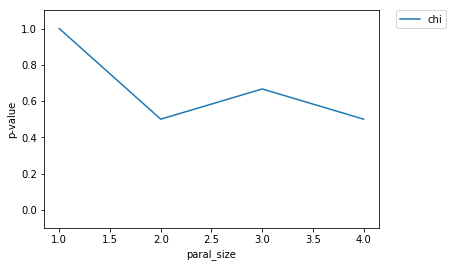

In [17]:
plt.ylim(-0.1, 1.1)
for name in tests:
    plt.plot(paral_sizes, pvalues[name], label=name)
plt.xlabel('paral_size')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


## Round-robin

In [18]:
def round_distributed_test(test, sample, paral_size=10):
    distributed_sample = defaultdict(list)
    for i in range(len(sample)):
        distributed_sample[i % paral_size].append(sample[i])

    params = [1.16, 3]
    pvalues = []
    for ds in distributed_sample:
        power, beta = parameter_estimation(distributed_sample[ds], params)
        pvalues.append(test(get_sample(distributed_sample[ds]), power, beta))

    return pvalues


In [19]:
paral_sizes = range(1, 5)
pvalues = defaultdict(list)
sample = get_sample(words)

for name in tests:
    for ps in paral_sizes:
        loc_pvalues = round_distributed_test(tests[name], sample, paral_size=ps)
        pvalues[name].append(sum(loc_pvalues) / ps)


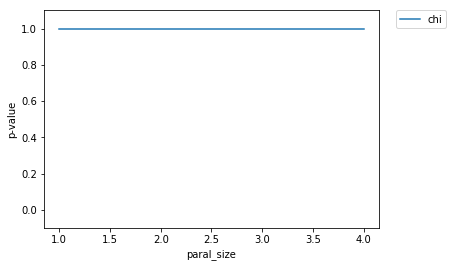

In [20]:
plt.ylim(-0.1, 1.1)
for name in tests:
    plt.plot(paral_sizes, pvalues[name], label=name)
plt.xlabel('paral_size')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
